## 0- Packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
from treeinterpreter import treeinterpreter as ti
% matplotlib inline

## 1- Data visualisation

In [60]:
raw_data=pd.read_csv('Telco.csv')
#raw_data.info()

In [61]:
raw_data['TotalCharges']=raw_data['TotalCharges'].convert_objects(convert_numeric=True)
raw_data.dropna(inplace=True)
raw_data.reset_index(inplace=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [62]:
# let's work with artificially resampled data for the minority 
minority=raw_data[raw_data.Churn=='Yes']
majority=raw_data[raw_data.Churn=='No']
df_minority_upsampled = resample(minority, 
                                 replace=True,     
                                 n_samples=len(majority),    
                                 random_state=123)
data_bal=pd.concat([df_minority_upsampled,majority])
data_bal=data_bal.reset_index()
del data_bal['index']

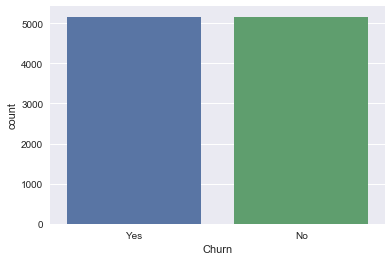

In [63]:
sns.countplot(data_bal['Churn'])

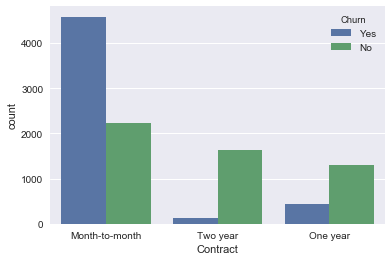

In [64]:
sns.countplot(x='Contract',data=data_bal,hue='Churn')

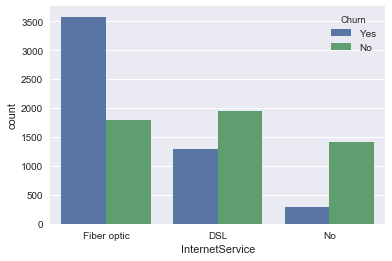

In [65]:
sns.countplot(x='InternetService',data=data_bal,hue='Churn')

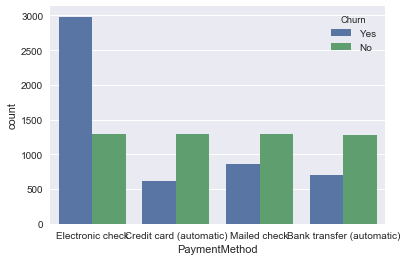

In [66]:
sns.countplot(x='PaymentMethod',data=data_bal,hue='Churn')
# churn très élevés pour les electronic check

## 2- Data mining

### convert cat to dummies

In [67]:
categorical_var=['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [69]:
# convert the categorical variables
data=pd.get_dummies(data_bal[categorical_var],drop_first=True)
data['Churn']=data_bal['Churn']
data['MonthlyCharges']=data_bal['MonthlyCharges']
data['tenure']=data_bal['tenure']
data['TotalCharges']=data_bal['TotalCharges']
data['customerID']=data_bal['customerID'] # here we keep the variable customerID for further interpretation

### remove colinearity for explanatory variables

In [78]:
def remove_col_var(data,obj,thres):
    d={}
    obj=[obj,'customerID'] # here we keep the variable customerID for further interpretation
    for col in list(data.drop(obj,axis=1).columns):
        d[col]=np.sum(data.drop(obj,axis=1).corr()[col].apply(lambda z : (abs(z)>thres)))
    corr_var=[key for key in d.keys() if d[key]!=1]
    cols=data.drop(obj,axis=1).columns
    dropped=[]
    for col in corr_var:
        L=list(data.corr()[abs(data.corr()[col])>thres][col].index)
        l=list(pd.DataFrame({'value':data.corr()[abs(data.corr()[col])>thres][col]},index=L).
               sort_values(by='value', axis=0, ascending=False).index) 
        if len(l)>2:
            l=l[1:-1]
            if l:
                cols=[cols[i] for i in range(len(cols)) if cols[i] not in l]
                dropped.extend(l)
        if len(l)==2:
            l=l[1:]
            cols=[cols[i] for i in range(len(cols)) if cols[i] not in l]
            dropped.extend(l)
    cols.extend(obj)        
    return data[cols]

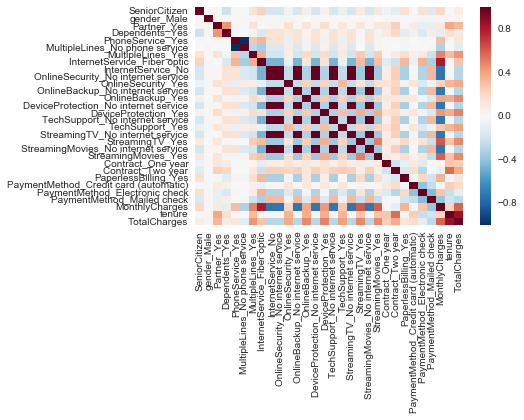

In [204]:
#sns.heatmap(data.corr())
# the explanatory variables are less correlated now

### keep most important features

In [76]:
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
def keep_important_features(data,obj,thres):
    y=data[obj].apply(lambda z: int(z=='Yes'))
    obj=[obj,'customerID']# here we keep the variable customerID for further interpretation
    X=data.drop(obj,axis=1)
    rlasso = RandomizedLasso(alpha=0.04)
    rlasso.fit(X, y)
    ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), X.columns)
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, verbose =3 )
    rfe.fit(X,y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)),  X.columns, order=-1)
    # Using Linear Regression
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    ranks["LinReg"] = ranking(np.abs(lr.coef_),  X.columns)

    # Using Ridge 
    ridge = Ridge(alpha = 7)
    ridge.fit(X,y)
    ranks['Ridge'] = ranking(np.abs(ridge.coef_),  X.columns)

    # Using Lasso
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso"] = ranking(np.abs(lasso.coef_),  X.columns)

    r={}
    for name in X.columns:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    cols_to_keep=meanplot[meanplot['Mean Ranking']>=thres]['Feature']
    l=list(cols_to_keep)
    l.extend(obj)
    return data[l]

### Final data set

In [81]:
data_f=remove_col_var(keep_important_features(data,'Churn',0.04),'Churn',0.85)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.

In [82]:
X=data_f
y=data_f['Churn']
X_train, X_test, y_train, y_test = train_test_split(X.drop(['Churn','customerID'],axis=1), y, test_size=0.30, random_state=101)

## 3- ML modeling

### log regression

In [18]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [19]:
print(confusion_matrix(y_test,predictions))

[[1160  399]
 [ 320 1219]]


In [20]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         No       0.78      0.74      0.76      1559
        Yes       0.75      0.79      0.77      1539

avg / total       0.77      0.77      0.77      3098



### tree

In [83]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

         No       0.92      0.83      0.87      1559
        Yes       0.84      0.93      0.88      1539

avg / total       0.88      0.88      0.88      3098



[[1295  264]
 [ 108 1431]]


## 4- Interpretations - Ad Hoc analysis

In [232]:
# we randomly pick 3 customers
test=X.sort_values(by='customerID').iloc[0:3]

In [233]:
raw_data[raw_data['customerID'].isin(list(test['customerID']))]

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2302,2307,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,No
3482,3488,0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,No
3838,3845,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,Yes


In [234]:
#rfc.predict(test.drop(['customerID','Churn'],axis=1))
prediction, bias, contributions = ti.predict(rfc, test.drop(['customerID','Churn'],axis=1))

In [235]:
prediction

array([[ 0.89,  0.11],
       [ 0.82,  0.18],
       [ 0.05,  0.95]])

In [236]:
for i in range(len(test)):
    print ("example", i+1)
    print ("Feature contributions")
    zipped=zip([contributions[i][j][1] for j in range(len(contributions[0]))], list(X_train.columns))
    sorted_zip=sorted(zipped, key=lambda x: -x[0])
    for c, feature in sorted_zip:
        print (feature+' : '+ str(c))
    print ("-"*20)

example 1
Feature contributions
tenure : 0.0884923729053
Contract_Two year : 0.0384463598092
StreamingMovies_No internet service : 0.0274685861787
PaperlessBilling_Yes : 0.0182588783883
InternetService_No : 0.0148652307161
StreamingTV_Yes : 0.00821348359434
OnlineSecurity_Yes : 0.00797194370309
PaymentMethod_Credit card (automatic) : 0.000830885973094
SeniorCitizen : -0.00242485835002
MultipleLines_Yes : -0.00304255533715
DeviceProtection_Yes : -0.0129491963127
PaymentMethod_Mailed check : -0.0151022671159
StreamingMovies_Yes : -0.0159751775517
Dependents_Yes : -0.0376615190778
TechSupport_Yes : -0.0580112400849
Partner_Yes : -0.0596521529263
PaymentMethod_Electronic check : -0.0620871903733
InternetService_Fiber optic : -0.0756655959732
MonthlyCharges : -0.1058971357
Contract_One year : -0.148246810406
--------------------
example 2
Feature contributions
Contract_Two year : 0.0503942304495
StreamingMovies_No internet service : 0.0399361374849
Contract_One year : 0.0370545811929
Online

In [201]:
def compare_contributions(var,churn):
    churned=X[X.Churn==churn].drop_duplicates(subset='customerID')
    prediction, bias, contributions = ti.predict(rfc, churned.drop(['customerID','Churn'],axis=1))
    distrib=[contributions[i][list(X.columns).index(var)][1] for i in range(len(contributions))]
    sns.distplot(distrib,bins=20)

In [230]:
print(frequency_highest_contrib('tenure','Yes'))
print(frequency_highest_contrib('MonthlyCharges','Yes'))
print(frequency_highest_contrib('PaymentMethod_Electronic check','Yes'))
print(frequency_highest_contrib('InternetService_Fiber optic','Yes'))

0.532267275842
0.280411193604
0.113649343232
0.0348372358652


In [218]:
def frequency_highest_contrib(var,churn):
    churned=X[X.Churn==churn].drop_duplicates(subset='customerID')
    prediction, bias, contributions = ti.predict(rfc, churned.drop(['customerID','Churn'],axis=1))
    n=np.sum([contributions[i][list(X.columns).index(var)][1]==np.max([contributions[i][j][1] for j in range(len(contributions[i]))]) for i in range(len(contributions))])
    return(n/len(churned))

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


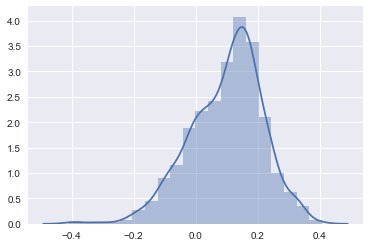

In [202]:
compare_contributions('tenure','Yes')

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


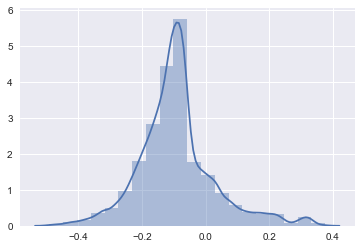

In [203]:
compare_contributions('tenure','No')

## 5- Scoring